Цепляем тауны с обеспеченностью

In [4]:
import requests
res = requests.get('http://10.32.1.42:5500/layer/towns?region_id=1')

In [12]:
import geopandas as gpd
towns = gpd.GeoDataFrame.from_features(res.json()['features'], crs=4326)
del towns['id']
del towns['name']
del towns['provision']

In [16]:
towns = towns.rename(columns=lambda c : c.removeprefix('provision_'))

In [33]:
towns.to_crs(towns.estimate_utm_crs(), inplace=True)

Считаем нужное

In [24]:
SPEED = 60 * 1000 / 60 # meters / min

In [26]:
from townsnet.utils import SERVICE_TYPES

service_types = {st['name']: st['accessibility'] for st in SERVICE_TYPES}

In [34]:
import geopandas as gpd
grid = gpd.read_file('grid_population_score.geojson')[['geometry']].to_crs(towns.crs)

In [ ]:
def get_indicators(provs: dict[str, tuple], min_provision=0.8):
    dicts = []
    for service_type, prov_tuple in provs.items():
        _, _, towns_gdf, _ = prov_tuple
        _, territory_dict = self.get_context_provision(service_type, towns_gdf)
        dicts.append(
            {
                "category": service_type.category.name,
                "infrastructure": service_type.infrastructure.name,
                "service_type": service_type.name,
                "weight": service_type.weight,
                **territory_dict,
            }
        )
    indicators = pd.DataFrame(dicts).set_index("service_type", drop=True)
    indicators["assessment"] = indicators.apply(
        lambda s: s["weight"] if s["provision"] >= min_provision else 0, axis=1
    )
    basic, basic_plus, comfort = indicators.groupby("category").agg({"assessment": "sum"})["assessment"]
    return indicators, basic + basic_plus / 4 + comfort / 4

In [76]:
import pandas as pd

MIN_PROV = 0.5

def provisions_to_assessment(provisions : dict[str, float]):
  st_df = pd.DataFrame(SERVICE_TYPES).set_index('name', drop=True)
  st_df['provision'] = provisions
  st_df = st_df[st_df.provision >= MIN_PROV]
  st_df = st_df.groupby('category').agg({'weight':'sum'})['weight']
  basic = st_df.loc['basic'] if 'basic' in st_df.index else 0
  basic_plus = st_df.loc['basic_plus'] if 'basic_plus' in st_df.index else 0
  comfort = st_df.loc['comfort'] if 'comfort' in st_df.index else 0
  return basic + basic_plus / 4 + comfort / 4

def get_polygon_provisions(polygon) -> float:
  # отбираем гдфы
  towns_gdf = towns.copy()
  towns_gdf['distance'] = towns_gdf.distance(polygon)
  provisions = {}
  for service_type, accessibility in service_types.items():
    towns_sub_gdf = towns_gdf[towns_gdf['distance'] <= accessibility * SPEED]
    provisions[service_type] = round(towns_sub_gdf[service_type].mean(),2)
  return provisions

def get_cell_prov(polygon):
  provs = get_polygon_provisions(polygon)
  return provisions_to_assessment(provs)

grid['social'] = grid.geometry.apply(get_cell_prov)

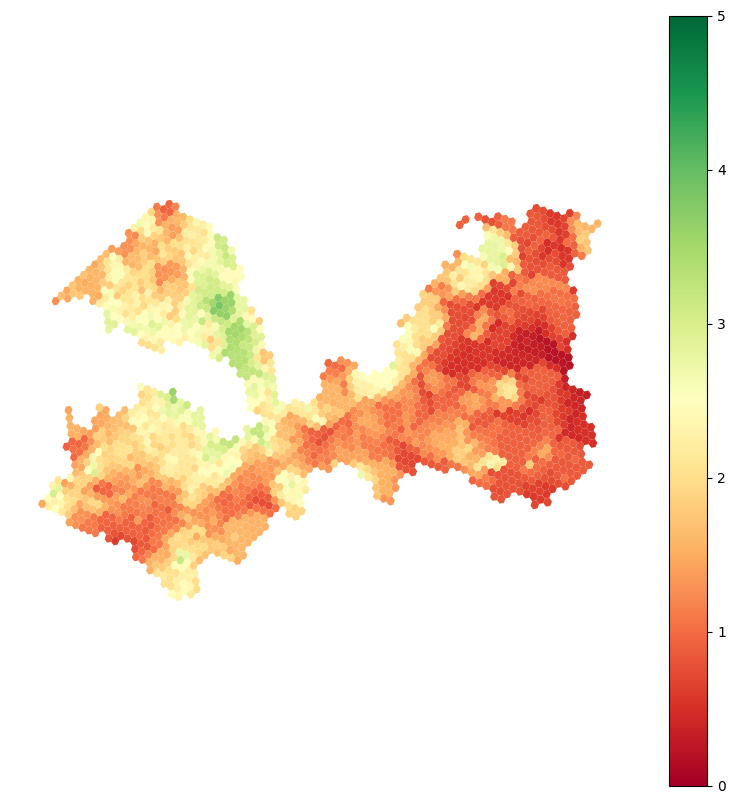

In [79]:
grid.plot(column='social', cmap='RdYlGn', figsize=(10,10), vmax=5, vmin=0, legend=True).set_axis_off()

In [78]:
grid.to_crs(4326).to_file('grid_social.geojson')